In [1]:
import os
import sys
# Construct the path to the directory you want to import from
# '..' goes up one directory level. Adjust as needed.
module_path = os.path.abspath(os.path.join('..'))

# Add the directory to sys.path
if module_path not in sys.path:
    sys.path.append(module_path)


from gridworld_env_layout import GridWorldMDPFromLayoutEnv
from gridworld_env import NoisyLinearRewardFeaturizedGridWorldEnv
import numpy as np

from agent.q_learning_agent import ValueIteration, PolicyEvaluation
from scipy.optimize import linprog

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


## Testing transition for GridWorldMDPFromLayoutEnv

In [2]:

layout = [
    ["red",   "green", "red"],
    ["red","red","red"],
]
color_to_feature_map = {
    "red":    [1,0,0],
    "green":  [0,1,0],
    "blue":   [0,0,1],
    "yellow": [1,1,0],
    "purple": [1,0,1],
    "orange": [0,1,1],
}

env = GridWorldMDPFromLayoutEnv(
    gamma=0.9,
    layout=layout,
    color_to_feature_map=color_to_feature_map,
    noise_prob=0,         # slip prob
    terminal_states=[]      # no terminals for this printout
)

print("transitions shape:", env.transitions.shape)  # (6, 4, 6) for 2x3

action_names = ["UP","DOWN","LEFT","RIGHT"]

# A) Print each action's full transition matrix (rounded)
np.set_printoptions(precision=3, suppress=True)
for a, name in enumerate(action_names):
    print(f"\n=== Action {name} ({a}) ===")
    print(env.transitions[:, a, :].round(3))

# B) Print only nonzeros for each (state, action) row
print("\n=== Per-state nonzero entries (s -> next:prob) ===")
for s in range(env.num_states):
    print(f"\nState s={s}:")
    for a, name in enumerate(action_names):
        row = env.transitions[s, a, :]
        nz = np.nonzero(row)[0]
        parts = [f"{j}:{row[j]:.3f}" for j in nz]
        print(f"  {name:<5} -> " + ", ".join(parts) + f" | sum={row.sum():.3f}")


transitions shape: (6, 4, 6)

=== Action UP (0) ===
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]

=== Action DOWN (1) ===
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

=== Action LEFT (2) ===
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]

=== Action RIGHT (3) ===
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]

=== Per-state nonzero entries (s -> next:prob) ===

State s=0:
  UP    -> 0:1.000 | sum=1.000
  DOWN  -> 3:1.000 | sum=1.000
  LEFT  -> 0:1.000 | sum=1.000
  RIGHT -> 1:1.000 | sum=1.000

State s=1:
  UP    -> 1:1.000 | sum=1.000
  DOWN  -> 4:1.000 | sum=1.000
  LEFT  -> 0:1.000 | sum=1.000
  RIGHT -> 2:1.000 | sum=1.000

State s=2:
  UP    -> 2:1.000 | sum=1.0

## Testing transition for NoisyLinearRewardFeaturizedGridWorldEnv

In [3]:
# Make a 2x2 env with no terminal states so we can inspect the raw transitions
env = NoisyLinearRewardFeaturizedGridWorldEnv(
    gamma=0.9,
    size=2,                # 2x2 grid ⇒ 4 states
    noise_prob=0.1,        # slip probability
    num_features=4,
    terminal_states=[],    # no terminals for this printout
    include_terminal=False # don't force self-loops
)

print("transitions shape:", env.transitions.shape)  # expect (4, 4, 4)

action_names = ["UP", "DOWN", "LEFT", "RIGHT"]
np.set_printoptions(precision=3, suppress=True)

# A) Full transition matrix per action
for a, name in enumerate(action_names):
    print(f"\n=== Action {name} ({a}) ===")
    print(env.transitions[:, a, :].round(3))

# B) Per-(state, action) row: show only nonzeros + row sum
print("\n=== Per-state nonzero entries (s -> next:prob) ===")
for s in range(env.num_states):
    print(f"\nState s={s}:")
    for a, name in enumerate(action_names):
        row = env.transitions[s, a, :]
        nz = np.nonzero(row)[0]
        parts = [f"{j}:{row[j]:.3f}" for j in nz]
        print(f"  {name:<5} -> " + ", ".join(parts) + f" | sum={row.sum():.3f}")

# Optional: show the terminal-behavior variant (last state is terminal)
env_term = NoisyLinearRewardFeaturizedGridWorldEnv(
    gamma=0.9,
    size=2,
    noise_prob=0.1,
    num_features=4,
    terminal_states=[3],   # bottom-right as terminal
    include_terminal=True
)
print("\n--- With terminal state at index 3 (self-loops) ---")
for a, name in enumerate(action_names):
    row = env_term.transitions[3, a, :]
    nz = np.nonzero(row)[0]
    parts = [f"{j}:{row[j]:.3f}" for j in nz]
    print(f"Terminal row, action {name}: " + ", ".join(parts) + f" | sum={row.sum():.3f}")

transitions shape: (4, 4, 4)

=== Action UP (0) ===
[[0.9 0.1 0.  0. ]
 [0.1 0.9 0.  0. ]
 [0.8 0.  0.1 0.1]
 [0.  0.8 0.1 0.1]]

=== Action DOWN (1) ===
[[0.1 0.1 0.8 0. ]
 [0.1 0.1 0.  0.8]
 [0.  0.  0.9 0.1]
 [0.  0.  0.1 0.9]]

=== Action LEFT (2) ===
[[0.9 0.  0.1 0. ]
 [0.8 0.1 0.  0.1]
 [0.1 0.  0.9 0. ]
 [0.  0.1 0.8 0.1]]

=== Action RIGHT (3) ===
[[0.1 0.8 0.1 0. ]
 [0.  0.9 0.  0.1]
 [0.1 0.  0.1 0.8]
 [0.  0.1 0.  0.9]]

=== Per-state nonzero entries (s -> next:prob) ===

State s=0:
  UP    -> 0:0.900, 1:0.100 | sum=1.000
  DOWN  -> 0:0.100, 1:0.100, 2:0.800 | sum=1.000
  LEFT  -> 0:0.900, 2:0.100 | sum=1.000
  RIGHT -> 0:0.100, 1:0.800, 2:0.100 | sum=1.000

State s=1:
  UP    -> 0:0.100, 1:0.900 | sum=1.000
  DOWN  -> 0:0.100, 1:0.100, 3:0.800 | sum=1.000
  LEFT  -> 0:0.800, 1:0.100, 3:0.100 | sum=1.000
  RIGHT -> 1:0.900, 3:0.100 | sum=1.000

State s=2:
  UP    -> 0:0.800, 2:0.100, 3:0.100 | sum=1.000
  DOWN  -> 2:0.900, 3:0.100 | sum=1.000
  LEFT  -> 0:0.100, 2:0.900 | s

In [4]:
import numpy as np

# ---- 2x3 layout using only names your renderer supports ('red','blue',...) ----
layout = [
    ["blue",  "red", "blue"],
    ["blue", "blue",  "blue"],
]

# ---- 2 features per color: [feat0, feat1] ----
#     Here: 'red' activates feature0, 'blue' activates feature1
color_to_feature_map = {
    "red":  [1.0, 0.0],
    "blue": [0.0, 1.0],
}

# ---- Custom feature weights (your class normalizes these internally) ----
custom_feature_weights = [-2.0, -1.0]   # favor 'red' cells, penalize 'blue' cells

# ---- Optional terminal (goal) at bottom-right: index = 1*3 + 2 = 5 ----
goal_idx = 2
terminal_states = [goal_idx]           # or [] if you don't want terminals

env = GridWorldMDPFromLayoutEnv(
    gamma=0.95,
    layout=layout,
    color_to_feature_map=color_to_feature_map,
    noise_prob=0.1,
    terminal_states=terminal_states,
    custom_feature_weights=custom_feature_weights,   # <--- custom weights in use
)

# Sanity checks
print("rows x cols:", env.rows, "x", env.columns)      # 2 x 3
print("num features:", env.num_features)                    # 2
print("feature_weights (normalized by class):", env.feature_weights)

# Reward of a few states (flat indices)
print("R(0) [red] =", env.compute_reward(0))           # dot([1,0], w) -> ~ + (normalized)
print("R(1) [blue]=", env.compute_reward(1))           # dot([0,1], w) -> ~ - (normalized)
print("R(5) [goal] =", env.compute_reward(5))

# Start and take a couple of steps
obs = env.reset(fixed_start=True)   # starts at (0,0)
print("Initial obs:", obs)
obs, r, done, _ = env.step(3)       # try RIGHT
print("After RIGHT -> reward:", r, "done:", done)

rows x cols: 2 x 3
num features: 2
feature_weights (normalized by class): [-0.89442719 -0.4472136 ]
R(0) [red] = -0.4472135954997579
R(1) [blue]= -0.8944271909995158
R(5) [goal] = -0.4472135954997579
Initial obs: {'agent': array([0, 0], dtype=int32), 'terminal states': [2]}
After RIGHT -> reward: -0.8944271909995158 done: False


In [5]:
rows, cols = 2, 3

# ---------- 2) Run Value Iteration ----------
vi = ValueIteration(env)
V = vi.run_value_iteration(epsilon=1e-10)
policy = vi.get_optimal_policy()
Q = vi.get_q_values(V)

# ---------- 3) Pretty print results ----------
print("\n=== Feature weights actually used (class normalizes custom weights) ===")
print(env.feature_weights)

print("\n=== State values V(s) as a 2x3 grid ===")
print(np.round(V.reshape(rows, cols), 4))

arrow = {0:"^", 1:"v", 2:"<", 3:">"}
print("\n=== Greedy policy (arrows), 'T' marks terminal ===")
policy_grid = np.full((rows, cols), "", dtype=object)
for s, a in policy:
    r, c = divmod(s, cols)
    policy_grid[r, c] = "T" if s in env.terminal_states else arrow[a]
print(policy_grid)

print("\n=== Q-values per state (rows: states 0..5, cols: actions [UP,DOWN,LEFT,RIGHT]) ===")
np.set_printoptions(precision=4, suppress=True)
print(Q)

# (Optional) quick sanity checks
print("\nR(0) (red):", env.compute_reward(0))
print("R(1) (goal, blue):", env.compute_reward(1))
print("Transitions shape:", env.transitions.shape)
print("Row sums for (state=0, action=RIGHT):", env.transitions[0,3,:].sum())


=== Feature weights actually used (class normalizes custom weights) ===
[-0.89442719 -0.4472136 ]

=== State values V(s) as a 2x3 grid ===
[[-1.6144 -0.6619  0.    ]
 [-1.6104 -1.1274 -0.6125]]

=== Greedy policy (arrows), 'T' marks terminal ===
[['>' '>' 'T']
 ['>' '>' '^']]

=== Q-values per state (rows: states 0..5, cols: actions [UP,DOWN,LEFT,RIGHT]) ===
[[-1.9351 -1.9321 -1.9805 -1.6144]
 [-1.4614 -1.4574 -1.8889 -0.6619]
 [ 0.      0.      0.      0.    ]
 [-1.9343 -1.9312 -1.9775 -1.6104]
 [-1.5192 -1.5152 -1.8858 -1.1274]
 [-0.6125 -1.078  -1.3622 -0.9709]]

R(0) (red): -0.4472135954997579
R(1) (goal, blue): -0.8944271909995158
Transitions shape: (6, 4, 6)
Row sums for (state=0, action=RIGHT): 1.0


## Sanity check for value iteration algorithm

In [6]:
import numpy as np

# --- Build your 2x3 env (no rendering) ---
layout = [
    ["red",  "blue", "red"],
    ["blue", "red",  "blue"],
]
color_to_feature_map = {
    "red":  [1.0, 0.0],
    "blue": [0.0, 1.0],
}
goal_idx = 1
env = GridWorldMDPFromLayoutEnv(
    gamma=0.95,
    layout=layout,
    color_to_feature_map=color_to_feature_map,
    noise_prob=0.1,
    terminal_states=[goal_idx],
    custom_feature_weights=[-0.01, 1.0],
    render_mode=None,
)

# Convenience
S = env.get_num_states()
A = env.get_num_actions()
W = env.size               # width (columns); used by divmod(s, W)
gamma = env.get_discount_factor()

# ---------- 1) Transition matrix invariants ----------
row_sums = env.transitions.sum(axis=2)
assert np.allclose(row_sums, 1.0, atol=1e-12), "Some (s,a) rows do not sum to 1."
assert np.all(env.transitions >= -1e-12), "Negative probabilities found."
for t in env.terminal_states:
    for a in range(A):
        row = env.transitions[t, a, :]
        assert np.count_nonzero(row) == 1 and np.isclose(row[t], 1.0), "Terminal not strict self-loop."

# ---------- 2) Reward mapping check ----------
def manual_reward(s):
    r, c = divmod(s, W)
    feats = env.grid_features[r, c]          # numeric feature vector (new implementation)
    return float(np.dot(feats, env.feature_weights))

for s in range(S):
    assert np.isclose(env.compute_reward(s), manual_reward(s)), f"Reward mismatch at state {s}"

# ---------- 3) Run VI and check Bellman residual ----------
vi = ValueIteration(env)
V = vi.run_value_iteration(epsilon=1e-10)
residual = []
for s in range(S):
    backs = [np.dot(env.transitions[s, a, :], V) for a in range(A)]
    T_V_s = env.compute_reward(s) + gamma * np.max(backs)
    residual.append(abs(T_V_s - V[s]))
bellman_inf = np.max(residual)
print("Bellman residual (∞-norm):", bellman_inf)
assert bellman_inf < 1e-7, "Bellman residual too large; VI may not have converged."

# ---------- 4) V = max_a Q(s,a) ----------
Q = vi.get_q_values(V)
assert np.allclose(V, Q.max(axis=1), atol=1e-8), "V != max_a Q(s,a)"

# ---------- 5) Greedy policy evaluation ≈ V ----------
policy = vi.get_optimal_policy()
pe = PolicyEvaluation(env, policy=policy, uniform_random=False)
V_pi = pe.run_policy_evaluation(epsilon=1e-10)
diff = np.max(np.abs(V_pi - V))
print("||V_pi - V||_∞:", diff)
assert diff < 1e-7, "Greedy policy evaluation doesn't match V*."

# ---------- 6) Analytic toy: 1x3 line, noise=0, terminal with unit reward ----------
layout_line = [["red", "red", "blue"]]   # blue is goal with reward 1, red = 0
cmap_line = {"red":[0.0, 0.0], "blue":[0.0, 1.0]}
gamma_line = 0.9
goal_line = 2
env_line = GridWorldMDPFromLayoutEnv(
    gamma=gamma_line,
    layout=layout_line,
    color_to_feature_map=cmap_line,
    noise_prob=0.0,
    terminal_states=[goal_line],
    custom_feature_weights=[0.0, 1.0],   # only goal rewards
    render_mode=None,
)

vi_line = ValueIteration(env_line)
V_line = vi_line.run_value_iteration(epsilon=1e-12)

V_goal = 1.0 / (1.0 - gamma_line)               # self-loop with reward 1
assert np.isclose(V_line[goal_line], V_goal, atol=1e-8), "Goal value incorrect in 1x3."
# one and two steps away (optimal path RIGHT)
assert np.isclose(V_line[1], gamma_line * V_goal, atol=1e-8)
assert np.isclose(V_line[0], (gamma_line**2) * V_goal, atol=1e-8)

# ---------- 7) Edge cases ----------
# gamma=0 => V(s) = R(s)
# orig_gamma = env.gamma
# env.gamma = 0.0
# V0 = ValueIteration(env).run_value_iteration(epsilon=1e-12)
# R = np.array([env.compute_reward(s) for s in range(env.get_num_states())])
# assert np.allclose(V0, R, atol=1e-10), "With gamma=0, V should equal rewards."
# env.gamma = orig_gamma  # restore

print("All sanity checks passed ✅")


Bellman residual (∞-norm): 0.9999500037486876


AssertionError: Bellman residual too large; VI may not have converged.

## Sanity check for value iteration wiht NoisyLinearRewardFeaturizedGridWorldEnv

In [7]:
import numpy as np

# --- paste in your ValueIteration class here (with the γ=0 guard fix if you added it) ---

# --- import your env class ---
# from your_module import NoisyLinearRewardFeaturizedGridWorldEnv

# Build a 3x3 goal-reaching env
size = 3
goal_state = size*size - 1  # bottom-right index 8

env = NoisyLinearRewardFeaturizedGridWorldEnv(
    gamma=0.95,
    size=size,
    num_features=2,          # exactly two features
    noise_prob=0.10,         # slip noise
    terminal_states=[goal_state],
    include_terminal=True,
    goal_reaching=True,      # not strictly needed once we set custom weights
    seed=0
)

# Make features deterministic: all non-terminal = [1,0], goal = [0,1]
grid = np.zeros((size, size, 2), dtype=float)
grid[..., 0] = 1.0                      # everyone gets feature 0
gr, gc = divmod(goal_state, size)
grid[gr, gc] = np.array([0.0, 1.0])     # goal gets feature 1
env.grid_features = grid

# Set custom feature weights to strongly favor the goal feature
env.set_feature_weights(np.array([0.0, 1.0]))  # will be normalized to [0,1]

# ----- run value iteration -----
VI = ValueIteration(env)
V = VI.run_value_iteration(epsilon=1e-10)
policy = VI.get_optimal_policy()

# Pretty-print state values as 3x3
print("State values (reshape 3x3):")
print(V.reshape(size, size))

# Pretty-print greedy policy as arrows
arrow = {0:"^", 1:"v", 2:"<", 3:">", None:"·"}
pi_grid = np.array([arrow[a] for (_,a) in policy]).reshape(size, size)
# Mark terminal explicitly
pi_grid[gr, gc] = "G"
print("\nGreedy policy:")
for r in range(size):
    print(" ".join(pi_grid[r]))

# A couple of quick sanity checks
assert policy[goal_state][1] is not None  # terminal self-loop exists (action value defined)
# Values should generally increase toward the goal (not a strict proof because of noise, but indicative)
print("\nQuick check: Value at start (0,0) =", V[0], "  Value at goal (2,2) =", V[goal_state])


State values (reshape 3x3):
[[0.81662704 0.864383   0.91423106]
 [0.864383   0.92053695 0.98060885]
 [0.91423106 0.98060885 0.        ]]

Greedy policy:
v > v
v v v
> > G


AssertionError: 

## Initialize the env

In [39]:
# --- Build your 2x3 env (no rendering) ---
layout = [
    ["blue",  "red", "blue"],
    ["blue", "blue",  "blue"],
]
color_to_feature_map = {
    "red":  [1.0, 0.0],
    "blue": [0.0, 1.0],
}
rows, cols = 2, 3
#goal_idx = 2
W_TRUE = np.array([-1, -1])/np.linalg.norm([-1, -1])
env = GridWorldMDPFromLayoutEnv(
    gamma=0.99,
    layout=layout,
    color_to_feature_map=color_to_feature_map,
    noise_prob=0,
    terminal_states=[0],
    custom_feature_weights=W_TRUE,
    render_mode=None,
)

vi = ValueIteration(env)
V = vi.run_value_iteration(epsilon=1e-10)  # already uses γ and a norm-based threshold

policy = vi.get_optimal_policy()
policy

[(0, None), (1, 2), (2, 2), (3, 0), (4, 0), (5, 0)]

## Differenr way to compute succesor features using q value which counts for multiple optimal actions

In [40]:
import numpy as np

def build_Pi_from_q(env, q_values, tie_eps=1e-10):
    """
    Return Π(s,a) from Q(s,a): uniform over all a achieving max Q(s,·).
    Terminal rows are left zero (P_pi fallback makes them self-loops).
    """
    S, A = env.get_num_states(), env.get_num_actions()
    Pi = np.zeros((S, A), dtype=float)

    terminals = set(getattr(env, "terminal_states", []) or [])
    for s in range(S):
        if s in terminals:
            continue
        row = np.asarray(q_values[s], dtype=float)
        m = np.max(row)
        mask = np.abs(row - m) < tie_eps
        k = int(mask.sum())
        if k > 0:
            Pi[s, mask] = 1.0 / k
        else:
            # extremely rare: all -inf or nan -> fallback to uniform
            Pi[s, :] = 1.0 / A
    return Pi

def compute_successor_features_iterative_from_q(
    env,
    q_values,
    convention: str = "entering"
    "",
    zero_terminal_features: bool = True,
    tol: float = 1e-10,
    max_iters: int = 10000
):
    S, A, d = env.get_num_states(), env.get_num_actions(), env.num_features
    gamma = env.get_discount_factor()

    # Φ and T (your env already normalizes; if you prefer, use it directly)
    Phi = np.asarray(env.grid_features, float).reshape(S, d)
    if zero_terminal_features and getattr(env, "include_terminal", False):
        for t in (env.terminal_states or []):
            Phi[t] = 0.0
    T = np.asarray(env.transitions, float)

    # π from Q with ties handled
    Pi = build_Pi_from_q(env, q_values, tie_eps=1e-10)
    print("Pi from q: ", Pi)

    # P_π(s'|s) = sum_a Π(s,a) T(s'|s,a), with fallback self-loop if a row is zero
    P_pi = np.zeros((S, S), dtype=float)
    for s in range(S):
        P_pi[s] = Pi[s].dot(T[s])
        rs = P_pi[s].sum()
        if rs == 0.0:
            P_pi[s, s] = 1.0
        else:
            P_pi[s] /= rs

    # Iterative policy evaluation for μ(s)
    mu_s = np.zeros((S, d), dtype=float)
    use_enter = convention.lower().startswith("enter")

    for _ in range(max_iters):
        mu_old = mu_s.copy()
        for s in range(S):
            exp_mu_next = np.zeros(d)
            exp_phi_next = np.zeros(d) if use_enter else None
            for a in range(A):
                p_next = T[s, a]
                w = Pi[s, a]
                if w == 0.0:
                    continue
                exp_mu_next += w * (p_next @ mu_old)
                if use_enter:
                    exp_phi_next += w * (p_next @ Phi)
            mu_s[s] = (exp_phi_next if use_enter else Phi[s]) + gamma * exp_mu_next
        if np.max(np.abs(mu_s - mu_old)) < tol:
            break

    # ψ(s,a)
    mu_sa = np.zeros((S, A, d), dtype=float)
    for s in range(S):
        for a in range(A):
            p_next = T[s, a]
            exp_mu_next = p_next @ mu_s
            if use_enter:
                exp_phi_next = p_next @ Phi
                mu_sa[s, a] = exp_phi_next + gamma * exp_mu_next
            else:
                mu_sa[s, a] = Phi[s] + gamma * exp_mu_next

    return mu_sa, mu_s, Phi, P_pi


In [41]:
# mu_sa, mu_s, Phi, P_pi = compute_successor_features_iterative_from_q(
#     env,
#     vi.get_q_values(),
# )

mu_sa, mu_s, Phi, P_pi = compute_successor_features_iterative_from_q(
    env,
    vi.get_q_values(),
)

Pi from q:  [[0.  0.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  1.  0. ]
 [1.  0.  0.  0. ]
 [0.5 0.  0.5 0. ]
 [0.5 0.  0.5 0. ]]


In [42]:
for i in vi.get_q_values():
    print(i)

[0. 0. 0. 0.]
[-1.40714249 -2.10017785 -0.70710678 -2.10017785]
[-2.10017785 -2.78628285 -1.40714249 -2.10017785]
[-0.70710678 -1.40714249 -1.40714249 -2.10017785]
[-1.40714249 -2.10017785 -1.40714249 -2.78628285]
[-2.10017785 -2.78628285 -2.10017785 -2.78628285]


In [43]:
import numpy as np

# def derive_constraints_from_mu_sa_vec(
#     mu_sa: np.ndarray,       # (S, A, d)  action-SFs ψ(s,a)
#     pi_pairs,                # list[(state, action)]
#     env,
#     skip_terminals: bool = True,
#     normalize: bool = True,
# ):
#     """
#     Vectorized: build constraints v = ψ(s,a*) - ψ(s,b) for all b != a*.
#     Returns a list[(v, s, a_star, b)].
#     """
#     S, A, d = mu_sa.shape

#     # map (state, action) pairs -> a*(s); unspecified states set to -1
#     a_star = np.full(S, -1, dtype=int)
#     for s, a in pi_pairs:
#         a_star[int(s)] = int(a)

#     # skip terminals if requested
#     if skip_terminals and getattr(env, "include_terminal", False):
#         terms = np.array(env.terminal_states or [], dtype=int)
#         if terms.size:
#             a_star[terms] = -1

#     valid = np.where(a_star >= 0)[0]
#     if valid.size == 0:
#         return []

#     # ψ(s,a*) for valid states (Nv,d)
#     psi_star = mu_sa[valid, a_star[valid], :]              # (Nv, d)
#     # ψ(s,·) for valid states (Nv,A,d)
#     psi_all  = mu_sa[valid, :, :]                          # (Nv, A, d)
#     # differences for all b: (Nv, A, d)
#     diffs = psi_star[:, None, :] - psi_all

#     # mask out b == a*
#     mask = np.ones((valid.size, A), dtype=bool)
#     mask[np.arange(valid.size), a_star[valid]] = False

#     # flatten selections
#     v = diffs[mask]                                        # (Ncons, d)
#     s_idx = np.repeat(valid, A)[mask.ravel()]              # (Ncons,)
#     b_idx = np.tile(np.arange(A), valid.size)[mask.ravel()]
#     a_idx = np.repeat(a_star[valid], A)[mask.ravel()]

#     # drop near-zero vectors
#     nrm = np.linalg.norm(v, axis=1)
#     #keep = nrm > tol
#     #if not np.any(keep):
#     #    return []
#     #v, s_idx, a_idx, b_idx, nrm = v[keep], s_idx[keep], a_idx[keep], b_idx[keep], nrm[keep]
#     v, s_idx, a_idx, b_idx, nrm = v, s_idx, a_idx, b_idx, nrm

#     # normalize if requested
#     if normalize:
#         v = np.divide(v, nrm[:, None], out=v.copy(), where=nrm[:, None] > 0)

#     # pack result
#     return [(v[i], int(s_idx[i]), int(a_idx[i]), int(b_idx[i])) for i in range(v.shape[0])]

import numpy as np

def derive_constraints_from_q_ties(
    mu_sa: np.ndarray,        # (S, A, d) action-SFs ψ(s,a)
    q_values: np.ndarray,     # (S, A)     action values used to decide optimal set(s)
    env,
    tie_eps: float = 1e-10,
    skip_terminals: bool = True,
    normalize: bool = True,
    tol: float = 1e-12,
):
    """
    Build constraints v = ψ(s,a*) - ψ(s,b) for every state s, for every co-optimal a* in argmax Q(s,·),
    and for every non-optimal b ∉ argmax Q(s,·). This preserves all ties.

    Returns: list of (v, s, a_star, b) with v in R^d.
    """
    S, A, d = mu_sa.shape
    q = np.asarray(q_values, dtype=float)
    if q.shape != (S, A):
        raise ValueError(f"q_values shape {q.shape} != (S, A)=({S},{A})")

    # argmax set per state with tie tolerance
    m = np.max(q, axis=1, keepdims=True)
    argmax_mask = np.abs(q - m) <= tie_eps   # (S, A) True where action is co-optimal

    # optionally skip terminals
    if skip_terminals and getattr(env, "include_terminal", False):
        terms = np.array(getattr(env, "terminal_states", []) or [], dtype=int)
        if terms.size:
            argmax_mask[terms] = False  # no constraints emitted from terminals

    constraints = []
    for s in range(S):
        A_star = np.where(argmax_mask[s])[0]
        if A_star.size == 0:
            continue  # nothing to do (terminal or undefined)
        B = np.where(~argmax_mask[s])[0]
        if B.size == 0:
            # all actions are tied optimal at s -> no informative inequality constraints
            continue

        psi_s = mu_sa[s]  # (A, d)
        # for each co-optimal a*, build differences against all non-optimal b
        for a_star in A_star:
            diffs = psi_s[a_star][None, :] - psi_s[B, :]   # (|B|, d)
            norms = np.linalg.norm(diffs, axis=1)

            # optionally normalize and drop ~zero vectors
            for i, b in enumerate(B):
                if norms[i] <= tol:
                    continue
                v = diffs[i]
                if normalize:
                    v = v / norms[i]
                constraints.append((v, int(s), int(a_star), int(b)))

    return constraints

In [44]:
norm_vecs = derive_constraints_from_q_ties(mu_sa, vi.get_q_values(), env)

In [45]:
norm_vecs= [norm_vecs[i][0] for i in range(len(norm_vecs))] 
norm_vecs

[array([-1.,  0.]),
 array([-0.31432215, -0.94931638]),
 array([-0.7035446 , -0.71065111]),
 array([ 0.0099995, -0.99995  ]),
 array([ 0.11770932, -0.99304809]),
 array([ 0.0099995, -0.99995  ]),
 array([ 0., -1.]),
 array([ 0., -1.]),
 array([-0.31432215, -0.94931638]),
 array([ 0.32002753, -0.94740824]),
 array([ 0.11770932, -0.99304809]),
 array([-0.70710678, -0.70710678]),
 array([-0.51145358, -0.8593109 ]),
 array([ 0.20215129, -0.97935431]),
 array([ 0.20215129, -0.97935431]),
 array([-0.30858249, -0.95119758]),
 array([-0.30858249, -0.95119758])]

## removing redundant constraints

In [46]:
import numpy as np
from scipy.optimize import linprog

def _normalize_dir(v, tol=1e-12):
    """Normalize v up to positive scaling so duplicates collapse to same key."""
    v = np.asarray(v, dtype=float)
    nrm = np.linalg.norm(v)
    if nrm < tol:
        # Zero vector is not a valid halfspace normal for c^T w >= 0; skip it upstream
        return None
    v = v / nrm
    # Make a canonical sign: first nonzero component positive
    for x in v:
        if abs(x) > tol:
            if x < 0:
                v = -v
            break
    # Round for stable hashing
    return tuple(np.round(v, 12))

def is_redundant_constraint(h, H, epsilon=1e-4):
    """
    Return True if the inequality h^T w >= 0 is redundant given H w >= 0.
    """
    h = np.asarray(h, dtype=float)
    H = np.asarray(H, dtype=float)

    # If there are no other constraints, h cannot be redundant.
    if H.size == 0:
        return False

    # Ensure H is 2D with shape (m, n)
    if H.ndim == 1:
        H = H.reshape(1, -1)
    m, n = H.shape
    assert h.shape == (n,), f"Shape mismatch: h {h.shape} vs H (m={m}, n={n})"

    # Solve: minimize h^T w  s.t.  (-H) w <= 0,  bounds -1 <= w_i <= 1
    b = np.zeros(m)
    res = linprog(h, A_ub=-H, b_ub=b, bounds=[(-1, 1)]*n, method='highs')

    if res.status != 0:
        # Numerical hiccup: be safe and treat as necessary (not redundant).
        return False

    # If we can push h^T w below 0, then h is necessary; otherwise redundant.
    return res.fun >= -epsilon

def remove_redundant_constraints(halfspaces, epsilon=1e-4):
    """
    Return a list of non-redundant halfspace normals h such that h^T w >= 0.
    - Monotone build: test each h only against the set we've already kept.
    - Final cleanup pass removes any that became redundant after later additions.
    - Exact/positively-scaled duplicates are removed upfront.
    """
    halfspaces = [np.asarray(h, dtype=float) for h in halfspaces]

    # Filter out zeros and deduplicate by direction (up to positive scale)
    seen = set()
    unique = []
    for h in halfspaces:
        key = _normalize_dir(h)
        if key is None:
            continue  # skip zero normals
        if key not in seen:
            seen.add(key)
            unique.append(h)

    kept = []
    # First pass: only compare to what we've already kept (prevents "all dropped" bug)
    for h in unique:
        H_keep = np.vstack(kept) if len(kept) else np.empty((0, h.size))
        if not is_redundant_constraint(h, H_keep, epsilon):
            kept.append(h)

    # Final cleanup: check each kept constraint against all others kept
    final = []
    for i, h in enumerate(kept):
        others = [kept[j] for j in range(len(kept)) if j != i]
        H_others = np.vstack(others) if len(others) else np.empty((0, h.size))
        if not is_redundant_constraint(h, H_others, epsilon):
            final.append(h)

    return final


non_redundant_vecs = remove_redundant_constraints(np.array(norm_vecs), epsilon = 0.001)

In [47]:
norm_vecs

[array([-1.,  0.]),
 array([-0.31432215, -0.94931638]),
 array([-0.7035446 , -0.71065111]),
 array([ 0.0099995, -0.99995  ]),
 array([ 0.11770932, -0.99304809]),
 array([ 0.0099995, -0.99995  ]),
 array([ 0., -1.]),
 array([ 0., -1.]),
 array([-0.31432215, -0.94931638]),
 array([ 0.32002753, -0.94740824]),
 array([ 0.11770932, -0.99304809]),
 array([-0.70710678, -0.70710678]),
 array([-0.51145358, -0.8593109 ]),
 array([ 0.20215129, -0.97935431]),
 array([ 0.20215129, -0.97935431]),
 array([-0.30858249, -0.95119758]),
 array([-0.30858249, -0.95119758])]

In [53]:
non_redundant_vecs

[array([-1.,  0.]), array([ 0.32002753, -0.94740824])]

## visualize constraint

[[-1.         -1.        ]
 [-0.         -1.        ]
 [-0.         -0.        ]
 [-1.         -0.33779264]]


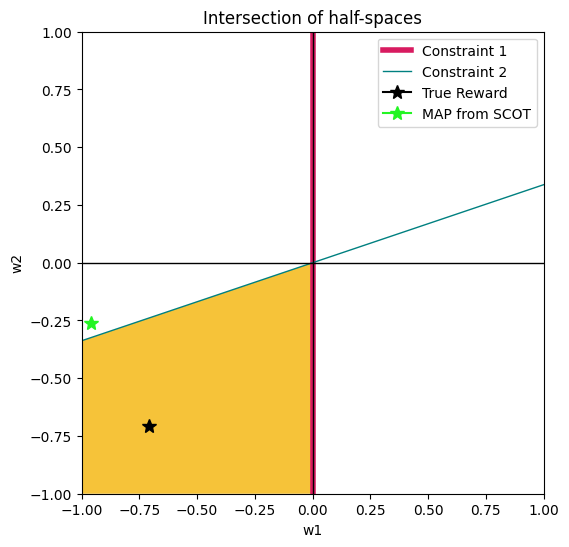

In [54]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def _intersection_polygon_2d(V, box=1.0, tol=1e-12):
    """
    Return vertices (k,2) of the bounded intersection:
        { w : w^T v_i >= 0 for all i }  ∩  { |w1|<=box, |w2|<=box }
    as a convex polygon ordered counter-clockwise.
    """
    V = np.asarray(V, float).reshape(-1, 2)

    # Convert to a_i x + b_i y + c_i <= 0 form (halfspace format)
    # w^T v >= 0  <=>  (-v)^T w <= 0  -> a=-vx, b=-vy, c=0
    half = [(-vx, -vy, 0.0) for (vx, vy) in V]

    # Bounding box (keeps region bounded for plotting)
    half += [( 1, 0, -box), (-1, 0, -box), (0, 1, -box), (0, -1, -box)]

    pts = []
    m = len(half)
    for i in range(m):
        a1, b1, c1 = half[i]
        for j in range(i + 1, m):
            a2, b2, c2 = half[j]
            D = a1 * b2 - a2 * b1
            if abs(D) < tol:
                continue  # parallel lines
            x = (b1 * c2 - b2 * c1) / D
            y = (c1 * a2 - c2 * a1) / D
            # keep if satisfies all halfspaces
            if all(a * x + b * y + c <= tol for (a, b, c) in half):
                pts.append((x, y))

    if not pts:
        return np.empty((0, 2))

    pts = np.unique(np.round(pts, 12), axis=0)  # dedup numerically
    c = pts.mean(axis=0)
    ang = np.arctan2(pts[:, 1] - c[1], pts[:, 0] - c[0])
    order = np.argsort(ang)
    return pts[order]

def plot_halfspace_intersection_2d(
    V,
    *,
    box=1.0,
    colors=None,
    labels=None,
    w_true=W_TRUE,
    title="Intersection of half-spaces"
):
    """
    V: (m,2) array of normals; each row v defines w^T v >= 0.
    box: plot window [-box, box]^2 and bounding halfspaces.
    colors/labels: optional per-constraint styling.
    w_true: optional (w1, w2) to mark with a star.
    """
    V = np.asarray(V, float).reshape(-1, 2)
    m = len(V)
    xs = np.linspace(-box, box, 400)

    if colors is None:
        colors = ["#d81b60", "#008080", "#1f77b4", "#ff7f0e"]  # magenta/teal first
    if labels is None:
        labels = [f"Constraint {i+1}" for i in range(m)]

    fig, ax = plt.subplots(figsize=(6, 6))

    # Draw each boundary v_x x + v_y y = 0
    handles = []
    for i, (vx, vy) in enumerate(V):
        col = colors[i % len(colors)]
        if abs(vy) < 1e-12:
            h = ax.axvline(0, color=col, lw=4, label=labels[i])
        else:
            y_line = -(vx / vy) * xs
            
            h, = ax.plot(xs, y_line, color=col, lw=1, label=labels[i])
        handles.append(h)

    # Compute and shade feasible polygon (hatched)
    poly = _intersection_polygon_2d(V, box=box)
    print(poly)
    if poly.shape[0] > 0:
        patch = Polygon(
            poly, closed=True, facecolor="#f5bd23", alpha=0.9,
            edgecolor="none", hatch="///"
        )
        ax.add_patch(patch)

    # Axes, limits, labels
    ax.axhline(0, color="k", lw=1)
    ax.axvline(0, color="k", lw=1)
    ax.set_xlim(-box, box)
    ax.set_ylim(-box, box)
    ax.set_aspect("equal", "box")
    ax.set_xlabel("w1")
    ax.set_ylabel("w2")

    # True reward (optional)
    if w_true is not None:
        ax.plot(w_true[0], w_true[1], marker="*", color="k", ms=10, label="True Reward")
        ax.plot(-0.96 , -0.26 , marker="*", color="#23f523", ms=10, label="MAP from SCOT")
        
    # Build a clean legend (constraint lines + star if present)
    if w_true is not None:
        ax.legend(loc="upper right")
    else:
        ax.legend(handles=handles, loc="upper right")

    ax.set_title(title)
    plt.show()

# non_redundant_vecs = [[-0.06628492, -0.99780074],[ 0., -1.],
# [-0.10710142,  0.9942481 ],
# [-0.25864806, -0.96597163],]

plot_halfspace_intersection_2d(non_redundant_vecs)

## generate trajs

In [23]:
# def generate_candidates(env, pi_star, num_rollouts_per_state=1, max_steps=15):
#     """
#     Generate trajectories as lists of (state, action) pairs by following a
#     deterministic policy given as a list of (state, action) pairs.
#     """
#     S = env.get_num_states()
#     A = env.get_num_actions()

#     # Build a deterministic action map; -1 means "no action specified for this state"
#     a_star = np.full(S, -1, dtype=int)
#     for s, a in pi_star:
#         a_star[int(s)] = int(a)

#     terminals = set(env.terminal_states or [])
#     T = env.transitions  # already row-stochastic, terminals are absorbing

#     trajectories = []
#     for start_s in range(S):
#         if start_s in terminals or a_star[start_s] < 0:
#             continue  # skip terminal starts or states without a specified action

#         for _ in range(num_rollouts_per_state):
#             tau, s, steps = [], int(start_s), 0
#             while steps < max_steps and s not in terminals:
#                 a = a_star[s]
#                 if a < 0:
#                     break  # hit a state without a specified action; stop this rollout
#                 tau.append((s, a))
#                 # Sample next state from T[s, a, :]
#                 s = int(np.random.choice(S, p=T[s, a]))
#                 steps += 1
#             trajectories.append(tau)

#     return trajectories


def generate_candidates_from_q(
    env,
    q_values,                      # shape (S, A)
    num_rollouts_per_state=10,
    max_steps=15,
    tie_eps=1e-10,
):
    """
    Generate trajectories as lists of (state, action) pairs by following a greedy
    policy derived from q_values, sampling next states from env.transitions.
    """
    S = env.get_num_states()
    A = env.get_num_actions()
    terminals = set(env.terminal_states or [])
    T = env.transitions   # already row-stochastic per your env

    # Precompute greedy action sets (allowing ties within tie_eps)
    opt_actions = [[] for _ in range(S)]
    for s in range(S):
        if s in terminals:
            continue
        row = q_values[s]
        max_q = np.max(row)
        opt_actions[s] = [a for a in range(A) if abs(row[a] - max_q) < tie_eps]

    
    #print(opt_actions)
    trajectories = []
    for start_s in range(S):
        if start_s in terminals or not opt_actions[start_s]:
            continue  # skip terminal starts or states with no valid action

        for _ in range(num_rollouts_per_state):
            tau, s, steps = [], int(start_s), 0
            print("starting state: ", s)
            while steps < max_steps and s not in terminals:
                acts = opt_actions[s]
                if not acts:
                    break
                print("optimal actions: ", acts)
                a = int(np.random.choice(acts))           # pick among optimal actions
                tau.append((s, a))
                s = int(np.random.choice(S, p=T[s, a]))   # sample next state from transitions
                steps += 1
            trajectories.append(tau)

    return trajectories

In [24]:
T_q = generate_candidates_from_q(env, vi.get_q_values(), max_steps=200)

starting state:  1
optimal actions:  [2]
starting state:  1
optimal actions:  [2]
starting state:  1
optimal actions:  [2]
starting state:  1
optimal actions:  [2]
starting state:  1
optimal actions:  [2]
starting state:  1
optimal actions:  [2]
starting state:  1
optimal actions:  [2]
starting state:  1
optimal actions:  [2]
starting state:  1
optimal actions:  [2]
starting state:  1
optimal actions:  [2]
starting state:  2
optimal actions:  [1]
optimal actions:  [2]
optimal actions:  [2]
optimal actions:  [0]
starting state:  2
optimal actions:  [1]
optimal actions:  [2]
optimal actions:  [2]
optimal actions:  [0]
starting state:  2
optimal actions:  [1]
optimal actions:  [2]
optimal actions:  [2]
optimal actions:  [0]
starting state:  2
optimal actions:  [1]
optimal actions:  [2]
optimal actions:  [2]
optimal actions:  [0]
starting state:  2
optimal actions:  [1]
optimal actions:  [2]
optimal actions:  [2]
optimal actions:  [0]
starting state:  2
optimal actions:  [1]
optimal action

In [25]:
vi.get_q_values()

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-1.09354587, -0.295536  , -0.09950372, -0.48766723],
       [-0.48766723, -0.39208435, -1.09354587, -0.48766723],
       [-0.09950372, -0.1980124 , -0.1980124 , -0.295536  ],
       [-1.09354587, -0.295536  , -0.1980124 , -0.39208435],
       [-0.48766723, -0.39208435, -0.295536  , -0.39208435]])

In [26]:
T_q

[[(1, 2)],
 [(1, 2)],
 [(1, 2)],
 [(1, 2)],
 [(1, 2)],
 [(1, 2)],
 [(1, 2)],
 [(1, 2)],
 [(1, 2)],
 [(1, 2)],
 [(2, 1), (5, 2), (4, 2), (3, 0)],
 [(2, 1), (5, 2), (4, 2), (3, 0)],
 [(2, 1), (5, 2), (4, 2), (3, 0)],
 [(2, 1), (5, 2), (4, 2), (3, 0)],
 [(2, 1), (5, 2), (4, 2), (3, 0)],
 [(2, 1), (5, 2), (4, 2), (3, 0)],
 [(2, 1), (5, 2), (4, 2), (3, 0)],
 [(2, 1), (5, 2), (4, 2), (3, 0)],
 [(2, 1), (5, 2), (4, 2), (3, 0)],
 [(2, 1), (5, 2), (4, 2), (3, 0)],
 [(3, 0)],
 [(3, 0)],
 [(3, 0)],
 [(3, 0)],
 [(3, 0)],
 [(3, 0)],
 [(3, 0)],
 [(3, 0)],
 [(3, 0)],
 [(3, 0)],
 [(4, 2), (3, 0)],
 [(4, 2), (3, 0)],
 [(4, 2), (3, 0)],
 [(4, 2), (3, 0)],
 [(4, 2), (3, 0)],
 [(4, 2), (3, 0)],
 [(4, 2), (3, 0)],
 [(4, 2), (3, 0)],
 [(4, 2), (3, 0)],
 [(4, 2), (3, 0)],
 [(5, 2), (4, 2), (3, 0)],
 [(5, 2), (4, 2), (3, 0)],
 [(5, 2), (4, 2), (3, 0)],
 [(5, 2), (4, 2), (3, 0)],
 [(5, 2), (4, 2), (3, 0)],
 [(5, 2), (4, 2), (3, 0)],
 [(5, 2), (4, 2), (3, 0)],
 [(5, 2), (4, 2), (3, 0)],
 [(5, 2), (4, 2), (3, 0)

## SCOT algorithm

In [27]:
def scot_greedy(U, T, mu_sa, normalize=True, round_decimals=12):
    """
    Greedy select a subset of trajectories D ⊆ T that covers as many constraint
    directions from U as possible. Coverage is by matching direction vectors.

    U: list[(v_hat, s, a_star, b)]  # constraint directions (v_hat usually unit-norm)
    T: list[list[(s, a)]]           # trajectories as (state, action) pairs
    mu_sa: np.ndarray, shape (S, A, d)
    Returns
    -------
    D : list of selected trajectories (subset of T)
    """

    S, A, d = mu_sa.shape

    # --- helper to build a hashable key for a direction vector ---
    def key_for(v):
        n = np.linalg.norm(v)
        if not np.isfinite(n) or n == 0.0:
            return ("ZERO",)                      # special bucket for all-zero constraints
        vv = v / n if normalize else v
        return tuple(np.round(vv, round_decimals))

    # --- index U by direction key (handle duplicates mapping to same key) ---
    key_to_indices = {}
    for idx, v_hat in enumerate(U):
        k = key_for(np.asarray(v_hat, dtype=float))
        key_to_indices.setdefault(k, []).append(idx)

    universe = set(range(len(U)))   # all constraint indices
    covered = set()                 # covered indices so far
    D = []                          # selected trajectories
    remaining_T = list(T)           # we may remove chosen ones to speed up
    print(T)
    # --- main greedy loop ---
    while True:
        uncovered = universe - covered
        if not uncovered or not remaining_T:
            break

        best_gain = 0
        best_idx = -1
        best_covered_by_tau = None

        # evaluate coverage gain for each candidate trajectory
        for i, tau in enumerate(remaining_T):
            covered_by_tau = set()
            for s, a in tau:
                # form differences ψ(s,a) - ψ(s,b) for all b != a
                psi_star = mu_sa[s, a]                  # (d,)
                for b in range(A):
                    if b == a:
                        continue
                    v = psi_star - mu_sa[s, b]          # (d,)
                    k = key_for(v)
                    if k in key_to_indices:
                        covered_by_tau.update(key_to_indices[k])

            gain = len(uncovered & covered_by_tau)
            if gain > best_gain:
                best_gain = gain
                best_idx = i
                best_covered_by_tau = covered_by_tau

        if best_idx < 0 or best_gain == 0:
            # no trajectory adds new coverage; stop
            break

        # select the best trajectory and update covered set
        tau_greedy = remaining_T.pop(best_idx)
        D.append(tau_greedy)
        covered |= best_covered_by_tau

    return D

In [28]:
D = scot_greedy(non_redundant_vecs, T_q, mu_sa)

[[(1, 2)], [(1, 2)], [(1, 2)], [(1, 2)], [(1, 2)], [(1, 2)], [(1, 2)], [(1, 2)], [(1, 2)], [(1, 2)], [(2, 1), (5, 2), (4, 2), (3, 0)], [(2, 1), (5, 2), (4, 2), (3, 0)], [(2, 1), (5, 2), (4, 2), (3, 0)], [(2, 1), (5, 2), (4, 2), (3, 0)], [(2, 1), (5, 2), (4, 2), (3, 0)], [(2, 1), (5, 2), (4, 2), (3, 0)], [(2, 1), (5, 2), (4, 2), (3, 0)], [(2, 1), (5, 2), (4, 2), (3, 0)], [(2, 1), (5, 2), (4, 2), (3, 0)], [(2, 1), (5, 2), (4, 2), (3, 0)], [(3, 0)], [(3, 0)], [(3, 0)], [(3, 0)], [(3, 0)], [(3, 0)], [(3, 0)], [(3, 0)], [(3, 0)], [(3, 0)], [(4, 2), (3, 0)], [(4, 2), (3, 0)], [(4, 2), (3, 0)], [(4, 2), (3, 0)], [(4, 2), (3, 0)], [(4, 2), (3, 0)], [(4, 2), (3, 0)], [(4, 2), (3, 0)], [(4, 2), (3, 0)], [(4, 2), (3, 0)], [(5, 2), (4, 2), (3, 0)], [(5, 2), (4, 2), (3, 0)], [(5, 2), (4, 2), (3, 0)], [(5, 2), (4, 2), (3, 0)], [(5, 2), (4, 2), (3, 0)], [(5, 2), (4, 2), (3, 0)], [(5, 2), (4, 2), (3, 0)], [(5, 2), (4, 2), (3, 0)], [(5, 2), (4, 2), (3, 0)], [(5, 2), (4, 2), (3, 0)]]


In [29]:
D

[[(2, 1), (5, 2), (4, 2), (3, 0)]]

## Train BIRL on data from non-terminal MDP

In [30]:
from reward_learning.birl import BIRL

In [31]:
result = [list(dict.fromkeys(D[0]))]
result

[[(2, 1), (5, 2), (4, 2), (3, 0)]]

In [36]:
result

[[(2, 1), (5, 2), (4, 2), (3, 0)]]

In [37]:
#demo = [(0,1), (3,3), (4,3), (5, 0)]

birl = BIRL(env, result[0], beta=10)

In [38]:
birl.run_mcmc(samples=3000, stepsize=0.15, adaptive=True)

MAP INSIDE the MCMC:  [-0.37955562  0.92516892]
MAP INSIDE the MCMC:  [-0.54579618  0.83791798]
MAP INSIDE the MCMC:  [-0.56971876  0.82183973]
MAP INSIDE the MCMC:  [-0.67740615  0.73560921]
MAP INSIDE the MCMC:  [-0.84499982  0.53476659]
MAP INSIDE the MCMC:  [-0.90826484  0.41839572]
MAP INSIDE the MCMC:  [-0.92520622  0.37946468]
MAP INSIDE the MCMC:  [-0.95073538  0.3100036 ]
MAP INSIDE the MCMC:  [-0.9556596   0.29447363]
MAP INSIDE the MCMC:  [-0.96470108  0.26334736]
MAP INSIDE the MCMC:  [-0.97623203  0.21672801]
MAP INSIDE the MCMC:  [-0.97202809 -0.23486465]
MAP INSIDE the MCMC:  [-0.96986095 -0.24365906]
MAP INSIDE the MCMC:  [-0.96950728 -0.2450625 ]
MAP INSIDE the MCMC:  [-0.9667046  -0.25589492]
MAP INSIDE the MCMC:  [-0.96505051 -0.26206396]
MAP INSIDE the MCMC:  [-0.96371419 -0.26693626]
MAP INSIDE the MCMC:  [-0.96360745 -0.26732132]
MAP INSIDE the MCMC:  [-0.96364358 -0.26719104]


In [ ]:
birl.map_sol

## Compute the policy loss for that

## Using learned reward function on the MDP with terminal state